In [ ]:
!pip install tensorflow-gpu==1.13.1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.13.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==1.13.1


In [ ]:
# IMPORT MODULES
import sys
from os.path import join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import ResNet50
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import tensorflow as tf
import tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from keras.layers import Conv2D,MaxPooling2D,Activation, BatchNormalization, Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import tensorflow as tf
import random
from sklearn.utils import shuffle
import os, warnings
warnings.filterwarnings('ignore')

In [ ]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
EPOCHS = 200

b = np.load('/content/breastmnist (1).npz')


x_train = b['train_images']
x_train = np.expand_dims(x_train, axis = 3)
y_train = b['train_labels']
y_train = to_categorical(y_train, 100)


val_images = b['val_images']
val_images = np.expand_dims(val_images, axis = 3)
val_labels = b['val_labels']
val_labels = to_categorical(val_labels, 100)


x_test = b['test_images']
y_test = b['test_labels']
x_train.shape, y_train.shape

((546, 28, 28, 1), (546, 100))

In [ ]:
def build_generator(latent_dimension):

    # Noise Input Layers
    noise_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(noise_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 7 * 7)(x)
    x = BatchNormalization()(x)
    noise_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)

    # Condition Input Layers
    condition_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 7 * 7)(x)
    x = BatchNormalization()(x)
    condition_input = Reshape((7, 7, 128), input_shape = (128 * 7 * 7, ))(x)

    # Combined Input
    combined_input = Concatenate()([noise_input, condition_input])

    # Generator Block 1
    x = UpSampling2D(size = (2, 2))(combined_input)
    x = Conv2DTranspose(64, (5, 5), padding = 'same')(x)
    x = Activation('tanh')(x)

    # Generator Block 2
    x = UpSampling2D(size = (2, 2))(x)
    x = Conv2DTranspose(1, (5, 5), padding = 'same')(x)
    output = Activation('tanh')(x)

    generator = Model([noise_input_placeholder, condition_input_placeholder], output, name = 'Generator')

    return generator

In [ ]:
def build_discriminator(image_shape, latent_dimension):

    # Image Input Layers
    image_input_placeholder = Input(image_shape)
    x = Conv2D(64, (5, 5), padding = 'same')(image_input_placeholder)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(128, (5, 5))(image_input_placeholder)
    x = Activation('tanh')(x)
    image_input = MaxPooling2D(pool_size = (2, 2))(x)

    # Condition Input Layers
    condition_input_placeholder = Input(shape = (latent_dimension, ))
    x = Dense(1024)(condition_input_placeholder)
    x = Activation('tanh')(x)
    x = Dense(128 * 12 * 12)(x)
    x = BatchNormalization()(x)
    condition_input = Reshape((12, 12, 128), input_shape = (128 * 12 * 12, ))(x)

    combined_input = Concatenate()([image_input, condition_input])

    x = Flatten()(combined_input)
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    output = Dense(1, activation = 'sigmoid')(x)

    discriminator = Model([image_input_placeholder, condition_input_placeholder], output, name = 'Discriminator')

    return discriminator


In [ ]:
def build_gan(generator, discriminator, image_shape, latent_dimension):
    noise_input_placeholder = Input(shape = (100, ), name = 'NoiseInput')
    condition_input_placeholder = Input(shape = (100, ), name = 'ConditionInput')
    generated_image = generator([noise_input_placeholder, condition_input_placeholder])
    discriminator.trainable = False
    validity = discriminator([generated_image, condition_input_placeholder])
    gan = Model([noise_input_placeholder, condition_input_placeholder], validity)
    return gan


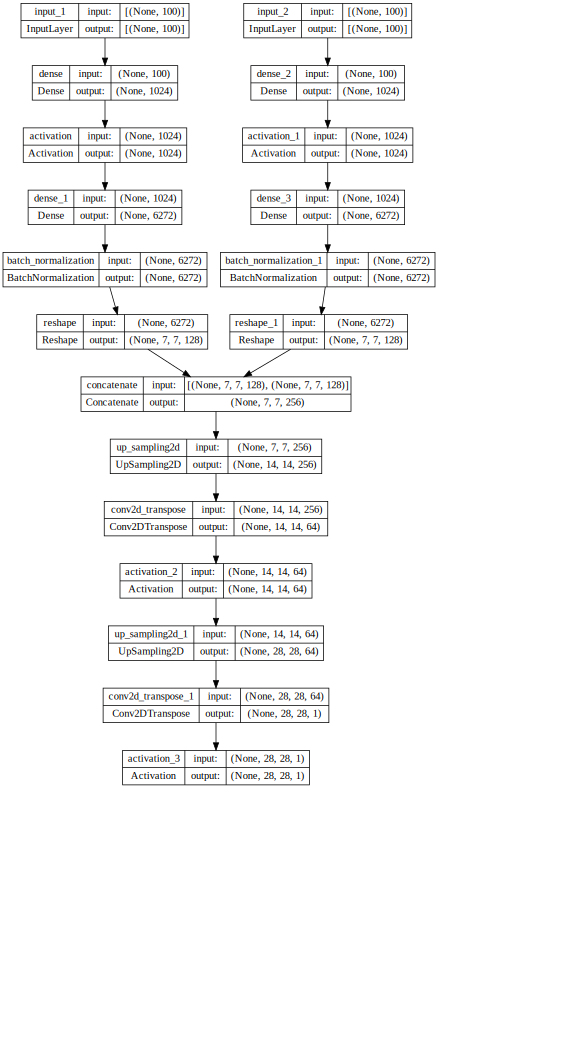

In [ ]:
generator = build_generator(100)
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

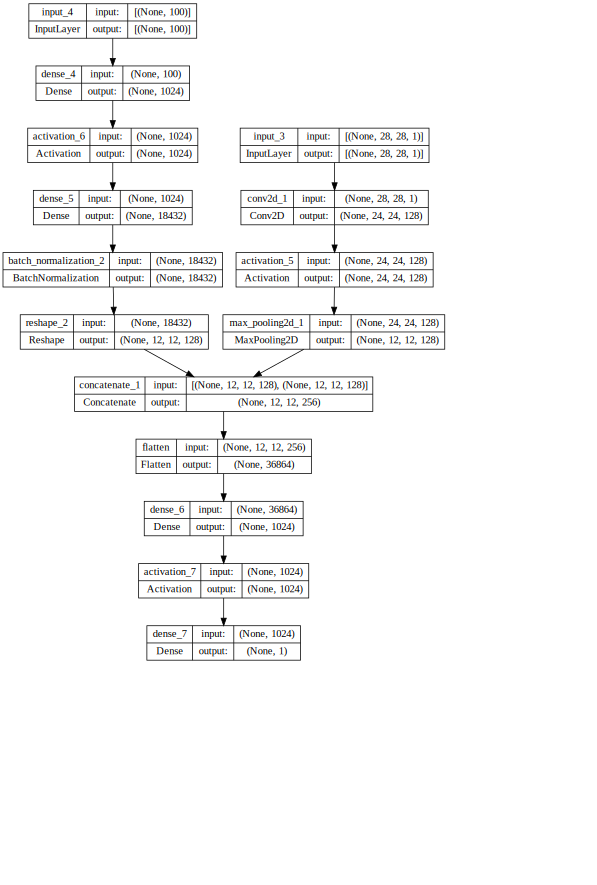

In [ ]:
discriminator = build_discriminator((28, 28, 1), 100)
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

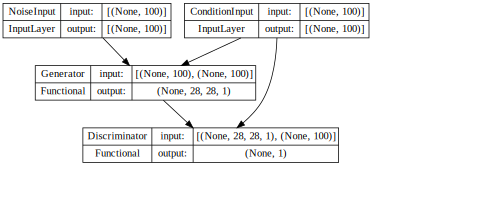

In [ ]:
gan = build_gan(generator, discriminator, (28, 28, 1), 100)
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [ ]:
generator = build_generator(100)
generator.summary()

discriminator = build_discriminator((28, 28, 1), 100)
discriminator.summary()

gan = build_gan(generator, discriminator, (28, 28, 1), 100)
gan.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 1024)         103424      ['input_5[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 1024)         103424      ['input_6[0][0]']                
                                                                                          

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)


generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
discriminator.trainable = True
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)



generator_loss_history_all = []
discriminator_loss_history_all = []

for epoch in range(EPOCHS):

    progress_bar = tqdm(desc = "Epoch: {0}".format(epoch), total = (x_train.shape[0] // BATCH_SIZE) * BATCH_SIZE)

    generator_loss_history, discriminator_loss_history = [], []

    for iteration in range(x_train.shape[0] // BATCH_SIZE):

        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))

        # Get a Batch from the dataset
        batch_images = x_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]
        batch_labels = y_train[iteration * BATCH_SIZE : (iteration + 1) * BATCH_SIZE]

        # Fake Images
        generated_images = generator.predict([noise, batch_labels])

        # Batch Dataset
        x = np.concatenate((batch_images, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        y = np.array(y)
        discriminator_conditions = np.concatenate((batch_labels, batch_labels))
        h = [x, discriminator_conditions]
        # Training the Discriminator
        discriminator_loss = discriminator.train_on_batch(h, y)
        discriminator_loss_history.append(discriminator_loss)
        discriminator_loss_history_all.append(discriminator_loss)

        noise = np.random.uniform(0, 1, size = (BATCH_SIZE, LATENT_DIMENSION))

        # Training the Generator
        discriminator.trainable = False
        c = [noise, batch_labels]
        p = np.array([1] * BATCH_SIZE)
        generator_loss = gan.train_on_batch(c , p)
        generator_loss_history.append(generator_loss)
        generator_loss_history_all.append(generator_loss)
        discriminator.trainable = True

        progress_bar.update(BATCH_SIZE)

Epoch: 0:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 1:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 2:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 3:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 4:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 5:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 6:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 7:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 8:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 9:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 10:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 11:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 12:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 13:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 14:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 15:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 16:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 17:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 18:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 19:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 20:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 21:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 22:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 23:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 24:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 25:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 26:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 27:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 28:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 29:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 30:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 31:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 32:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 33:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 34:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 35:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 36:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 37:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 38:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 39:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 40:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 41:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 42:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 43:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 44:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 45:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 46:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 47:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 48:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 49:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 50:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 51:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 52:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 53:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 54:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 55:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 56:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 13ms/step


Epoch: 57:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 58:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 12ms/step


Epoch: 59:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 25ms/step


Epoch: 60:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 61:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 62:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 63:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 64:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 65:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 66:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 67:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 68:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 69:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 70:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 71:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 72:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 73:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 74:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 75:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 76:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 77:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 78:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 79:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 80:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 81:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 82:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 83:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 84:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 85:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 86:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 87:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 88:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 89:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 90:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 91:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 92:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 93:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 94:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 95:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 96:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 97:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 98:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 99:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 100:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 101:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 102:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 103:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 104:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 105:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 106:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 107:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 108:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 109:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 110:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 11ms/step


Epoch: 111:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 112:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 113:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 114:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 115:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 116:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 117:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 118:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 119:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 120:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 121:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 122:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 123:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 124:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 125:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 126:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 127:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 128:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 129:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 130:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 131:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 132:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 133:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 134:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 135:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 136:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 137:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 14ms/step


Epoch: 138:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 139:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 140:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 141:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 142:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 143:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 11ms/step


Epoch: 144:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 145:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 146:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 147:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 148:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 149:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 150:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 151:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 152:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 153:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 154:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 155:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 156:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 157:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 158:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 159:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 13ms/step


Epoch: 160:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 161:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 162:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 163:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 164:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 165:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 166:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 167:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 168:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 169:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 170:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 171:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 172:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 11ms/step


Epoch: 173:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 174:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 175:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 176:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 177:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 178:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 179:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 180:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 181:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 182:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 183:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 184:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 185:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 186:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 11ms/step


Epoch: 187:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 188:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 189:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 8ms/step


Epoch: 190:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 191:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 192:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 4ms/step


Epoch: 193:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


Epoch: 194:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 7ms/step


Epoch: 195:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 196:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 10ms/step


Epoch: 197:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 6ms/step


Epoch: 198:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


Epoch: 199:   0%|          | 0/512 [00:00<?, ?it/s]

2/2 [==============================] - 0s 9ms/step


In [ ]:
# plot loss

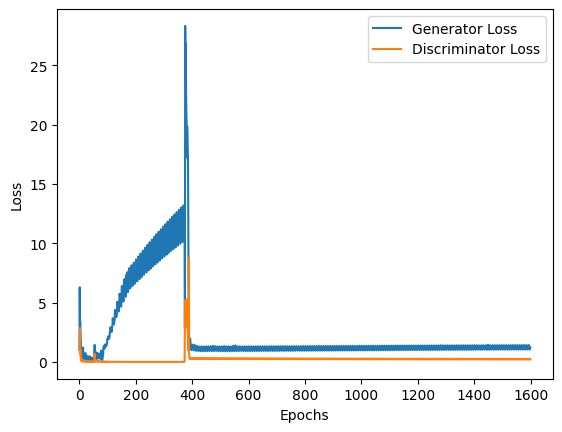

In [ ]:
plt.plot(generator_loss_history_all, label='Generator Loss')
# plot the discriminator loss curve
plt.plot(discriminator_loss_history_all, label='Discriminator Loss')
# add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# show the plot
plt.show()

0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 25ms/step


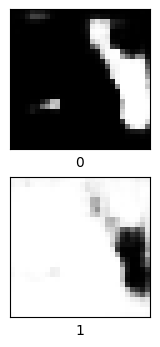

0
1/1 [==============================] - 0s 28ms/step
1
1/1 [==============================] - 0s 22ms/step


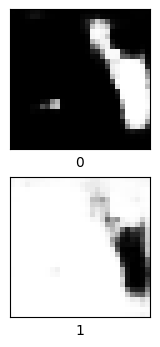

0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 20ms/step


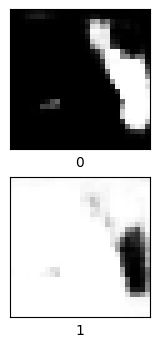

0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 22ms/step


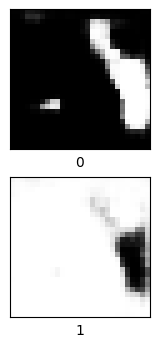

In [ ]:
for k in range(4):
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (4, 4))
    plt.setp(axes.flat, xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        print(i)
        noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
        condition = to_categorical(np.array([i]), LATENT_DIMENSION)
        generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.imshow(generated_image, cmap = 'gray')
        ax.set_xlabel(str(i))
    plt.show()



In [ ]:
#make 2000 image for every classes :

In [ ]:
all_array_image = []
all_label = []

for k in range(2000):
    for i, ax in enumerate(axes.flat):
        print(i)
        noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
        condition = to_categorical(np.array([i]), LATENT_DIMENSION)
        generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        np.array(all_array_image.append(generated_image))
        np.array(all_label.append(i))

np.savez('datag2.npz', all_array_image,all_label)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 29ms/step
0
1/1 [==============================] - 0s 25ms/step
1
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 24ms/step
1
1/1 [==============================] - 0s 28ms/step
0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 32ms/step
1
1/1 [==============================] - 0s 27ms/step
0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==========================

In [ ]:
all_array_image = []
all_label = []

for k in range(200):
    for i, ax in enumerate(axes.flat):
        print(i)
        noise = np.random.uniform(0, 1, size = (1, LATENT_DIMENSION))
        condition = to_categorical(np.array([i]), LATENT_DIMENSION)
        generated_image = generator.predict([noise, condition]).reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        np.array(all_array_image.append(generated_image))
        np.array(all_label.append(i))

np.savez('datag3.npz', all_array_image,all_label)


0
1/1 [==============================] - 0s 23ms/step
1
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 21ms/step
1
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 38ms/step
0
1/1 [==============================] - 0s 34ms/step
1
1/1 [==============================] - 0s 28ms/step
0
1/1 [==============================] - 0s 29ms/step
1
1/1 [==============================] - 0s 30ms/step
0
1/1 [==============================] - 0s 27ms/step
1
1/1 [==============================] - 0s 30ms/step
0
1/1 [==============================] - 0s 29ms/step
1
1/1 [==============================] - 0s 30ms/step
0
1/1 [=====================

In [ ]:
breastMNIST = np.load('/content/breastmnist (1).npz')
new_data = np.load('/content/datag3.npz')

In [ ]:
x1 = breastMNIST['train_images']
x2 = new_data['arr_0']
x_train_new = np.array(np.concatenate((x1, x2), axis=0))
x_train_new.shape

y1 = breastMNIST['train_labels']
y2 = new_data['arr_1']
y2 = y2.reshape(400,1)
y_train_new = np.array(np.concatenate((y1, y2), axis=0))

# Find indices of each class label
label_0_indices = np.where(y_train_new == 0)[0]
label_1_indices = np.where(y_train_new == 1)[0]

# Determine the smaller class size
min_class_size = min(len(label_0_indices), len(label_1_indices))
min_class_size=273
# Randomly sample the indices from each class
selected_indices = np.concatenate([
    np.random.choice(label_0_indices, size=min_class_size, replace=False),
    np.random.choice(label_1_indices, size=min_class_size, replace=False)
])

# Select the corresponding data based on the selected indices
selected_amount = x_train_new[selected_indices]
selected_label = y_train_new[selected_indices]

# Print the selected data
#print("Selected Amount:", selected_amount)
#print("Selected Label:", selected_label)

combined = list(zip(selected_amount, selected_label))

# Shuffle the combined array
random.shuffle(combined)

# Unpack the shuffled values into separate arrays
shuffled_x, shuffled_y = zip(*combined)

#print(shuffled_x)
#print(shuffled_y)

In [ ]:
x_train =shuffled_x
y_train= shuffled_y

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train = b['train_images']
x_train = np.stack((x_train,)*3, axis=-1)
y_train = b['train_labels']

val_images = breastMNIST['val_images']
val_images = np.stack((val_images,)*3, axis=-1)
val_labels = breastMNIST['val_labels']

x_test = breastMNIST['test_images']
x_test = np.stack((x_test,)*3, axis=-1)
y_test = breastMNIST['test_labels']
x_train.shape, x_test.shape

((546, 28, 28, 3), (156, 28, 28, 3))

In [ ]:
x_val = val_images
y_val = val_labels

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.mean = train_datagen.mean
val_datagen.std = train_datagen.std

test_datagen = ImageDataGenerator()
test_datagen.mean = train_datagen.mean
test_datagen.std = train_datagen.std

train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
val_generator = val_datagen.flow(x_val, y_val)
test_generator = test_datagen.flow(x_test, y_test)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers.experimental.preprocessing import Resizing

pretrained_Resnet = ResNet50( input_shape=(None,None,3),
                                  include_top=False,
                                  weights='imagenet',
                                  classes=2,
                                   )
# for layer in pretrained_Resnet.layers:
#      layer.trainable = False

Resnet50_model = Sequential()
# Resnet50_model.add(BatchNormalization())
Resnet50_model.add(Resizing(64,64))
# Resnet50_model.add(UpSampling2D(size=(7,7)))
Resnet50_model.add(pretrained_Resnet)
# for layer in pretrained_Resnet.layers:
#     Resnet50_model.add(layer)
for layer in Resnet50_model.layers:
    layer.trainable = False
# Resnet50_model.add(GlobalAveragePooling2D())
Resnet50_model.add(Flatten())
Resnet50_model.add(Dense(1024, activation='relu', name='hidden1'))
Resnet50_model.add(BatchNormalization())
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(512, activation='relu', name='hidden2'))
Resnet50_model.add(BatchNormalization())
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(2, activation='sigmoid', name='predictions'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
Resnet50_model.compile(
#     loss='sparse_categorical_crossentropy'
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])

# Callback to save the Keras model or model weights at some frequency.
checkpointer = ModelCheckpoint(
    filepath='Resnet50.h5', verbose=1, save_best_only=True)

history_Res_1 = Resnet50_model.fit(
    train_generator,
    epochs=200,
    verbose=1,
    callbacks=[checkpointer],
    validation_data=val_generator,
    shuffle=True)

Epoch 1/200
9/9 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9908
Epoch 1: val_loss improved from inf to 30.47501, saving model to Resnet50.h5
9/9 [==============================] - 7s 238ms/step - loss: 0.0270 - accuracy: 0.9908 - val_loss: 30.4750 - val_accuracy: 0.2564
Epoch 2/200
7/9 [======================>.......] - ETA: 0s - loss: 0.0093 - accuracy: 0.9976
Epoch 2: val_loss did not improve from 30.47501
9/9 [==============================] - 0s 33ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 30.7199 - val_accuracy: 0.2564
Epoch 3/200
7/9 [======================>.......] - ETA: 0s - loss: 0.0280 - accuracy: 0.9904
Epoch 3: val_loss did not improve from 30.47501
9/9 [==============================] - 0s 30ms/step - loss: 0.0257 - accuracy: 0.9890 - val_loss: 32.6409 - val_accuracy: 0.2564
Epoch 4/200
7/9 [======================>.......] - ETA: 0s - loss: 0.0318 - accuracy: 0.9856
Epoch 4: val_loss did not improve from 30.47501
9/9 [==============

Text(0.5, 1.0, 'Accuracy Curves')

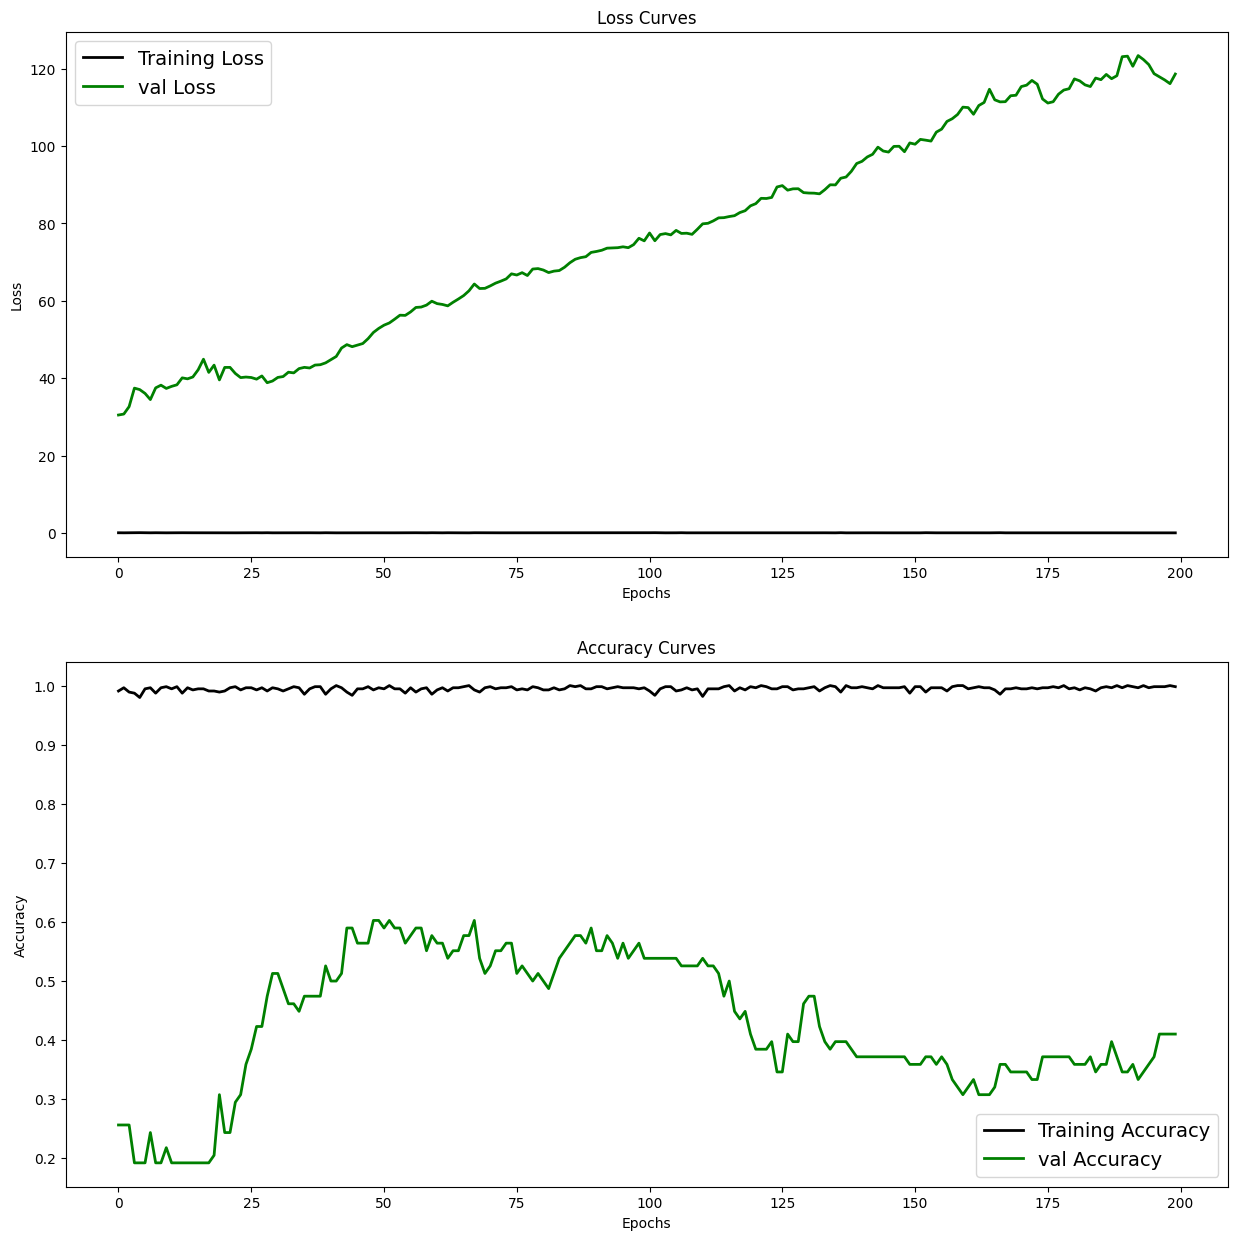

In [ ]:

## Loss curve
plt.figure(figsize=[15,15])
plt.subplot(211)
plt.plot(history_Res_1.history['loss'], 'black', linewidth=2.0)
plt.plot(history_Res_1.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'val Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)
## Acc curve
plt.subplot(212)
plt.plot(history_Res_1.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history_Res_1.history['val_accuracy'], 'green', linewidth=2.0)
plt.legend(['Training Accuracy', 'val Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [ ]:
test_loss, test_acc = Resnet50_model.evaluate(x_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

5/5 [==============================] - 2s 26ms/step - loss: 0.7989 - accuracy: 0.7564
Test loss: 0.7988921999931335
Test accuracy: 0.7564102411270142


In [ ]:
# Assuming you have a model, test data and labels
# Predict probabilities
y_pred = Resnet50_model.predict(x_test)
# Convert probabilities into class labels
y_pred = np.argmax(y_pred, axis=1)
# Convert true labels into class labels if they are one-hot encoded
y_test = np.argmax(y_test, axis=1)
# Import scikit-learn
from sklearn.metrics import confusion_matrix
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Print confusion matrix
print(cm)

5/5 [==============================] - 1s 21ms/step
[[ 16  26]
 [ 12 102]]
